# 实验6 文本风格生成

Author: 高鹏昺

Email: nbgao@126.com

Reference: https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation

## 1. Load Data

In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
print(all_characters)
n_characters = len(all_characters)
print('characters num:', n_characters)

file = unidecode.unidecode(open('../data/shakespeare.txt').read())
file_len = len(file)
print('file length:', file_len)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

characters num: 100
file length: 1115394


#### Random text chunk

In [4]:
chunk_len = 500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index: end_index]

print(random_chunk())

y to be hang'd,
That wilt not stay her tongue.

ANTIGONUS:
Hang all the husbands
That cannot do that feat, you'll leave yourself
Hardly one subject.

LEONTES:
Once more, take her hence.

PAULINA:
A most unworthy and unnatural lord
Can do no more.

LEONTES:
I'll ha' thee burnt.

PAULINA:
I care not:
It is an heretic that makes the fire,
Not she which burns in't. I'll not call you tyrant;
But this most cruel usage of your queen,
Not able to produce more accusation
Than your own weak-hinged fancy, s


## 2. Model

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        inputs = self.encoder(inputs.view(1, -1))
        outputs, hidden = self.gru(inputs.view(1, 1, -1), hidden)
        outputs = self.decoder(outputs.view(1, -1))
        return outputs, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

## 3. Inputs and Targets

In [6]:
def char_tensor(string):
    n = len(string)
    t = torch.zeros(n).long()
    for i in range(n):
        t[i] = all_characters.index(string[i])
    return Variable(t)

print(char_tensor('(abcdef,ABCDEF).'))

tensor([69, 10, 11, 12, 13, 14, 15, 73, 36, 37, 38, 39, 40, 41, 70, 75])


In [7]:
def random_training_set():
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

In [8]:
random_training_set()[0].shape

torch.Size([500])

## 4. Evaluation

In [34]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str).cuda()
    predicted = prime_str
    
    for p in range(len(prime_str)-1):
        _, hidden = decoder(prime_input[p], hidden)
    inputs = prime_input[-1]

    for p in range(predict_len):
        inputs = inputs.cuda()
        output, hidden = decoder(inputs, hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inputs = char_tensor(predicted_char)
    
    return predicted

## 5. Training

In [10]:
import time, math

def time_since(since):
    s = time.time() - since
    m = s // 60
    s -= m*60
    return '%dm %ds'%(m,s)

In [11]:
def train(inputs, target):
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        target = target.cuda()
    hidden = decoder.init_hidden().cuda()
    loss = 0
    for c in range(chunk_len):
        outputs, hidden = decoder(inputs[c], hidden)
        loss += criterion(outputs, target[c].view([1]))
    decoder.zero_grad()
    loss.backward()
    decoder_optimizer.step()
    return loss.data.item()/chunk_len

In [142]:
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 100
num_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, num_layers).cuda()
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

time_start = time.time()
loss_list = []
loss_avg = 0

for epoch in range(1, n_epochs+1):
    loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[Time: %s  Epoch: %d (%d%%)  Loss: %.4f]'%(time_since(time_start), epoch, epoch/n_epochs*100, loss))
        print(evaluate('Wh', 500), '\n')
        
    if epoch % plot_every == 0:
        loss_list.append(loss_avg/plot_every)
        loss_avg = 0

[Time: 0m 28s  Epoch: 100 (1%)  Loss: 2.2263]
Wh ind that in that shingirell heon-

O:
Thet to of love the ill ill sha, cosh ound to theld slet.

CENUIO:
Whou wet my caing ofos briono leat my she your both wing mith hersanue gracet sho= is dither.

NRIO Itut tht cones
Thoule and hoor froutod yous ow fork.

Sor tho he, me it this hy thous ueg imy clist rith iedow whey wies he that in al febay ang as shis welto crill mand thef the dom the prothee ta verers kist wiese,

CINETRO:

GRANUANRORCLRUS:
War, ave.

BAINOO:
Setle
What Sither,
I ware inte 

[Time: 0m 57s  Epoch: 200 (2%)  Loss: 2.0052]
Whink we with thour the pinn, inking and reare of wy thour moong
Her and and to seente whis have hald we it ferote,
Int do pisee noth our prelieps.

BOMENA:
Dis ague me, lackness me in wintminkes:
The feong me undend now ble sursechong litory and and wo mais sof allfbraring tis the prestere limpings gise nof to not rees that by dow
That noftit ting and you, hesy.

LYONASA:
We wordan, no dome on they


[Time: 7m 46s  Epoch: 1600 (16%)  Loss: 1.5435]
Wh and confould, betchind;
And a to live I should thou commond in the be lueps,
Mlack'd in turlow, my fits for coussides, slament. That a true love
In thinks thou a to sweaven of did my compelt
To make the some blanted the would the reased
The make the bridss the poor that and it to my fithed
The shall fried bend to he have the body:
I mead lidy a please be provisted thrance
Give from their this distile--
Some the ladds thy shall made, for the soencess.
Sistrust, I poor butle, my daughth.

QUEEN E 

[Time: 8m 16s  Epoch: 1700 (17%)  Loss: 1.7709]
What to the grow:
Is though Gart; and him be and pitters inger to swear,
Ting the may pray crelling God. In the coussing my beets Sweeper:
Thene sweat and knom the prepite him eart?

LUCIO:
Styen our Here int confeace me agaant:
That sake ars so fear thus the dispoin up thy sweet
Or king selante with sour'd it and heep
The did, bance not my beint be you dair hath well jod
Come to what towne you g

[Time: 15m 4s  Epoch: 3100 (31%)  Loss: 1.5656]
Whe carting the hast death,
To say in the saud's are may the would is be heral
To the within willfour wearty in as whose by make
shall nol, untant, 's the fair you, and live?

OFLOAY:
Thou have I'll all her reaturous doth,
And through you wornt prince.

LORD IV:
He with you we so honese is slave in Gent bank the erence: let hid,
When hount such by so whole in the harst; who man: and that head straint!
Your beshences best is is a'mweras themself and widtens.

LEONTES:
Secrew, now the double past th 

[Time: 15m 34s  Epoch: 3200 (32%)  Loss: 1.4410]
Whall wish; he love withter,
To-man thy is nirs how was I will, in the hold you goodly,
To viend this let mine wour in the long,
Make off the should should for the wipping this with for your worth.

HENRY GREY:
Here for thou weeps thee, o' this fished will,
If or the one thy both, have in thy fiend thee were:
Has her care, and thow days post rouses on, I state was my lord:
Now thou dound is main

[Time: 22m 21s  Epoch: 4600 (46%)  Loss: 1.6400]
WhIble mad?

ISABELLA:
I will being that crave your will the king king,
And posing the king company away to, all the beald,
Son the point for the meen substanion all his was is and the worr your fals you:
That an platters is bention good my lord,
What in this a falset renour the lord,
But that thou off the death do her see of strange
The movice morn as me,
As it by the liflly your reck'd by them
That no lords is the seing the have your seels meet?

GLOUCESTER:
Nay, for a bornion of the will for pl 

[Time: 22m 51s  Epoch: 4700 (47%)  Loss: 1.8509]
Wh.

KING RICHARD III:
Lost late: but as deathrod.

DUKE VINCENTIO:
Not makes my made she dough, the cassed
ROTUS, had lold this coumman.

MENENIUS:
Marry, Masabless! 'Back to thy love.

PRINCE:
Ay, posing! In of the loss o' the give he of the
The trumper out make you, love to so?
Hast frome then, and the none you styous shall
That your not repiry charefep, sowing one sat.

WARWICK:
No, at how 

[Time: 29m 39s  Epoch: 6100 (61%)  Loss: 1.7399]
What with the strongful.

YORK:
Dogless, sir! come, but done Seen:
Thou fasting in my her for let the comes you matker
How love to he to let's some fair soul,
If the not love of words
That sister nature this by me; the now,
To thy heard: his master sproud hear words,
You drun hature word fithing.

CENTIO:
What, sared, all still recother of was sir!
If you that thus not fis poss
That your fllation is to here, master,
If the sonsed mark uneping a served. I limbset and your subject.

CATES:
Biales sp 

[Time: 30m 8s  Epoch: 6200 (62%)  Loss: 1.6787]
What, the brother,
If I his an a resoly hands,
In a world this with the been this ame,
If his sent with enemery.

DUKE VINCENTIO:
Fair gance in the priess, what not death.

POMPEO:
What sing that the rooted thou to my go?

DUKE VINCENTIO:
Which head to gainth of means a friend,
I am baness thou eny's sonce! detwort'd.

PETRUCHIO:
Well be stronged again shall I double?

GLOUCESTER:
I and from my 

[Time: 36m 58s  Epoch: 7600 (76%)  Loss: 1.5052]
Whake all sust but croCun
'Tis pass the not approage an the presaming thing
You requisters to but mother.

QUEEN:
Not break of it is but of you show in stand,
And thou beay the jourse arkle it well they with him:
I housed that to swether's newn to you have thus recearce afrest,
And their earthy art to see all dowechold have to
queen a brother me the good was be should heaven,
Pertune of by me thou that deseech their in the behal,
Mark, the lanced gars so tale felling be seat
May thou harly never b 

[Time: 37m 27s  Epoch: 7700 (77%)  Loss: 1.6719]
Whow;
I speak as hant the give thy boword them stand own know
Gore the expostle do a father you do the
reads the house this someth,
What I will up on that within in the state
Of paling many unto garival for thee,
Stranget the she burding his pecertter thousand thee
in there mine's death this thy father the lance master
Thou lates to this indelen for many the brote,
As your to mine to should the

[Time: 44m 16s  Epoch: 9100 (91%)  Loss: 1.6936]
WhIThe in the work,
But the ever nome of the plainth,
Which in as the evering in these ungely,
And presently yalt for is in Bliging of make with therefore.

BUCKINGHAM:
This underishal be being on inicied,
And air ditter maning officers at on the caps:
Be rigly nobled with his see me hear onto?

ROMEO:
I shall the inful to thou hands, we all speak?

LUCENTIO:
'Tridds a say, can thou this?

PROMEREY:
I pass the distruction in that steech rear'd high
Be proyall death say out a ands,
And Clarence you 

[Time: 44m 45s  Epoch: 9200 (92%)  Loss: 1.4012]
Whe, brotherer:
I me tay a shall I being son, on her to thee
Is the men to will mune of it bring extreasing good upon an.

ISABELLA:
I world speak the see to tremen shorms now.

MONTAGER:
Why more for I will I the wor stand frows thee
The devilin lend fame us cohment by the entant
The in Romeo, and the beorn to gried master are to sweet.
Sesfull sovides, lamers distreas or she's a will a good g

In [12]:
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 256
num_layers = 1
lr = 0.01

decoder = RNN(n_characters, hidden_size, n_characters, num_layers).cuda()
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

time_start = time.time()
loss_list = []
loss_avg = 0

for epoch in range(1, n_epochs+1):
    loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[Time: %s  Epoch: %d (%d%%)  Loss: %.4f]'%(time_since(time_start), epoch, epoch/n_epochs*100, loss))
        print(evaluate('Wh', 200), '\n')
        
    if epoch % plot_every == 0:
        loss_list.append(loss_avg/plot_every)
        loss_avg = 0

[Time: 0m 29s  Epoch: 100 (1%)  Loss: 2.0512]
Where, shall'l to he he of them it yous ave will.

SOMICIUS:
And befor pirec, and sal thoun heif ringuer hen's hear here of shall gex wresosst thous the with her--and moner ont.

SAPELRA:
Your and nour  

[Time: 1m 0s  Epoch: 200 (2%)  Loss: 2.1931]
Why hell stay sood
To you say clave a lann mike a heave.

JULIET:
I conts any beageld the know.

POMIOLO:
Thang hanfcence of lace moodwiase hertu.

POLIGEL:
I same, hann hontere hime het.

JULIET:
I sea 

[Time: 1m 31s  Epoch: 300 (3%)  Loss: 2.0969]
Why, speth of mainte here and would whent rease the shards,
The not comorself
Sheret I do and be to and theseas the a peas, and treest tonly ply but of suppet this and pokest not pand thing forting ther 

[Time: 2m 2s  Epoch: 400 (4%)  Loss: 2.1520]
Whiche Coow then as:
Hou life,
Lor Comme he now new um, by had low
that word; be it my son sor to lame, has and thy for laster, my lighing my last lead,
And boy me ligne, thy bare;
To mand my love
I suc 

[Time: 17m 59s  Epoch: 3400 (34%)  Loss: 1.8956]
Whave Eughts:
I'll have son, Pardron,
Of my that they, not that heaven four brober his beath;
That heaven they and bo many her his.
Wend mistress, to me,
When the cillasdo,
Is I gentle man I confesse;
N 

[Time: 18m 28s  Epoch: 3500 (35%)  Loss: 1.8582]
Whink, and dow myselfs;
Nur think, I give, a for some before, hath not and love to him that lie and beharse a meals and like like to to solk fould beting in man.

DUKE O:
O chame play bead, are and me a 

[Time: 18m 58s  Epoch: 3600 (36%)  Loss: 1.9645]
Whill' like
Foul bear his lick well of time surent what reats and then trus will thins grance invenis it shall.

MIt
For deather sound suend vine
Fome ever pal. Bullly of to whis prightan.

MARIANIAN:
I 

[Time: 19m 28s  Epoch: 3700 (37%)  Loss: 1.9268]
Whick am subject
Is iss'd
If his bed
I and lest
reed sond me. Clarding bereadights. But his act sir, sull I canger, not agage a not the again,--
I am how I stanto hoose I sent him;
And han 

[Time: 34m 49s  Epoch: 6700 (67%)  Loss: 1.9533]
What were a our for andsel
Marreming in was and so do mighy such everes, me cursted of mirty.
Hor words, gree to in grack'd that and not dainciled ta!

ROMEOELLEY ANNE:
I my more she grace done do done  

[Time: 35m 22s  Epoch: 6800 (68%)  Loss: 1.7577]
Wh'ds sir musitte not weepasent in is sman:
If the moved streallong sleep is look wain, my sir.

KING RICHARD I MARm:
I spy seman is into with am of with sakeepes upon on or sir as chame ower sir.

Sirl 

[Time: 35m 52s  Epoch: 6900 (69%)  Loss: 1.7214]
Whand's thy slain a sils. of head.

PASTINCENTIO:
Test him the ring she's sern stating have the nirir, are her
The potise that I heardude thou:

ISABELLA:
To thou hord never thy bere him; shoullown, who 

[Time: 36m 23s  Epoch: 7000 (70%)  Loss: 2.0188]
Whast that was man manny:
I cell deads, an Padiled peaced with cold blod
Seconself nobliness anchange and that be giver;
I good shall not here of it not coursel sept all
My side, may mayst 

[Time: 51m 33s  Epoch: 10000 (100%)  Loss: 1.8415]
Which thee EDWARD:
Well not the breifet--

ESCALUS:
Why all to Lord to bell dendo from as my tender of master here my furbands a of my nie,
Which us a broother were eting and
Tererect tray; and the you  



## 6. Plot Training Loss

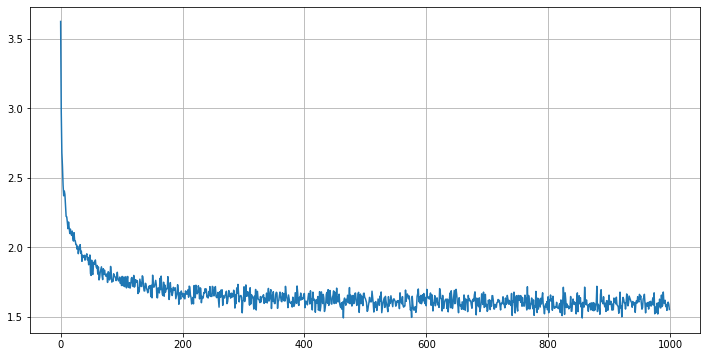

In [143]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(loss_list)
plt.grid()

## 7. Evaluating

In [144]:
print(evaluate('Th', 500, temperature=0.8))

Thing.

SICINIUS:
And we had, casty love me.

MERCUTIO:
Whom a gave loves wedl we'll patter.

JOHN OF YORK:
Harged to they take tunes what gentleman.

HERMIONE:
With my be ere his heart lord
But the love fatter thy good his the hands.

MERCUTIO:
A more so thy calm, if they many arms!
That his lover and the grave the gonds and prest
My bussible the princal thine childin
Where arrot to leard, who like enjoy.

DUKE VINCENTIO:
By songer the world.

ISABELLA:
As you arsun I speak and.

GLOUCESTER:
I we


In [14]:
print(evaluate('Th', 500, temperature=0.8))

Th Edward:
O the lentle of dience foer-sing
Yet at at a to the mayss flet molandst le's have dear blond late
Where der chope.

QUEEN ELIZABRET:
The was my coundingner--
A friend he were strand be roath deard gend reseher for for le to of the manasse.

EXEEETERCHUMINENENIUS:
Prom for may; uruny here take your may frager I can
to may from's me bringer;
Who my as take the exerself the king their and the encaissirer land kidion you and ender herce all not the shass
Well mand to a tarectrom I may speak
